# Predicting Customer IDs
## Demo for ACM FIU Workshop on Machine Learning - 3/20/2019

Welcome!

What follows is a quick demo of how to build a simple neural network classifier using pytorch to identify a customer id from log data.

### Dataset Description

This data comes from access logs for a popular piece of communication software. It logs various fields, including access times, IP adresses, operatings system used to log in, etc. This is from a real system so it has been anonymized to preserve both the company, and the user's privacy.

* Anonymization process preserved the data structure: e.g. same result for tenant ids, user emails etc
* Only see successful logins
* Each person only associated with a single tenant e.g. CustomerID/username for example
    * BrokeringUpn: abe.lincoln@usa.gov 
    * BrokeringUserFullName: abe.lincoln 
    * BrokeringUserName: USA\abe.lincoln

The full dataset is 1.9GB, so if you are interested in playing around with it, you can download it here: https://www.dropbox.com/s/sgotmtrrhtmk6b6/XAXD_events_all_time.anon.csv?dl=0. (Place it in the data folder if you want to re-run the preprocessing script.)

Fundamentally, this is a dataset of logon events, where in each case we have:
* Several fields that identify the user, with different levels of precision/trust/etc
* Several fields that identify their associated organization, probably with customerId as the canonical "tenant" identifier, but there is also org-level information in the domain portion of the email address fields (e.g. BrokeringUpn) and in the second part of the BrokeringUserName field (i.e., after the "\\").
* Fields containing the user's device name (ClientName), local OS (ClientPlatform) and version (ClientVersion), and IP address (I'm not sure the difference between the IP fields, and the original IPs were a mix of public/private IPs, but there's some information there)
* A handful of various datetimes for specific sub-events associated with the logon
* A few session IDs/keys. SIDs have some sub-structure insofar as stanzas may be common across records. E.g. one record might have value S-1-5-21-A-B-C-D, and another have value S-1-5-21-A-B-C-E.
* A few other misc attributes like IsApp, etc

Ideas  to look at:
* How many users will log in tomorrow, next week, etc? Overall, by org, etc.
* Are there different recognizable types of users based on behavior, usage patterns, etc?
* Are there different recognizable types of orgs based on collective behaviors and characteristics of their users, etc?
* Are there users who appear anomalous, either in general or suddenly one day, etc?
* How confidently can a user's identity be predicted based on features like
* Are there any discernable patterns around client platform, IP address, etc?
* Any patterns, predictability, etc around time durations within events, e.g. difference between LaunchRequestTime and ValidateSessionTime
* Are anonymous users (IsAnonymous=="true") different from identified users?
* Maybe something about understanding why some fields have unexpected values. E.g. records where BrokeringUpn is missing, or has something other than an email address (i.e., no "@")

### Now on to building our classifier!

## Step 1 - imports

We'll start by importing the necessary libraries and packages. Note: if you're running this notebook outside of colab, then you'll need to make sure the appropriate packages are installed.


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch import FloatTensor, LongTensor, max, device, cuda
from datasets import CustomerData
from models import IdNet
import numpy as np
import time

## Step 2 - Let's do some Exploratory Data Analysis

As I mentioned above, this data set is very large, so in an effort to speed things up, I've already preprocessed the data to remove and create a dataset with the features and labels, since we're going to approach this problem of creating a classifier to predict the customer id from the input features as a supervised learning problem.

### Explore the raw data

Let's take a look at the first few rows of the dataset.

In [23]:
# Let's load the data and take a look
train_df = pd.read_pickle("data/train_data.pickle")
train_df.head(10)

,customerId,st_weekday,st_seconds
0,2,0.333333,0.395907
1,3,0.000000,0.103960
2,0,0.833333,0.176530
3,1,0.500000,0.563791
4,1,0.833333,0.660667
8,3,1.000000,0.904142
10,2,0.000000,0.525018
13,3,0.666667,0.083971
16,0,0.000000,0.762844
17,0,0.000000,0.584590


We can see from the table, that we have two features, *st_weekday* and *st_seconds*, and one label, *customerId*. The features have already been normalized from 0 to 1 (it is easier for the net to use these as inputs and scaling gives equal weight the features so that no one feature dominates). The weekday column represents the day of the week, with 0 corresponding to Monday, and 1 corresponding to Sunday. The seconds column represents the number of seconds since 12:00AM. And finally, the customer id has been encoded from the true customer id to an integer from 0 to 3. There are way more than 4 customer ids in the raw dataset, however, the top four customers by volume of transaction records were selected and then re-balanced so that each customer id is represented an equal number of times.

Let's go ahead and do a scatter plot with the data to see if we can detect some usage patterns.

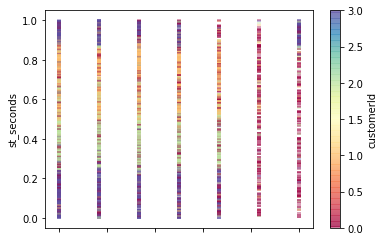

In [24]:
cmap = cm.get_cmap('Spectral')
train_df.sample(frac=0.05).plot.scatter(x='st_weekday',
                                        y='st_seconds',
                                        c='customerId',
                                        cmap=cmap,
                                        edgecolor=None,
                                        alpha=0.5,
                                        # s=100,
                                        marker="_")
plt.show()

It seems like some customers log in on different days, as well as at different points in the day. We may be able to build an ML algorithm to detect these patterns and predict, based on time of day and day of the week, which customers are loggin in.

## Step 3 - Load the data for training and testing

Here, there are a few classes that we need. One, *CustomerData*, is a custom dataset class that is derived from PyTorch's base dataset class. You can check out the implementation in the *datasets.py* file.

In [25]:
# Setup the data for training the model
train_dataset = CustomerData('data/train_data.pickle')
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Setup the data for testing the model
test_dataset = CustomerData('data/test_data.pickle')
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

## Step 4 - Setup our hyperparameters for training

**Hyperparameters** are parameters whose value are set before the learning process begins. As opposed to **parameters**, which refer to the parameters of the Machine Learning model that are learned during training.

In [26]:
# hyperparameters
num_epochs = 1
num_labels = 4
num_features = 2
log_interval = 100
n_hidden = 128
ngpu = 1

## Step 5 - Instantiate the Model, Optimizer, and Loss functions

Here, we'll instantiate the class that embodies the Neural Network. In our case, it as multilayer neural network with an input layer, an output layer, and 3 hidden layers. Each layer is successively smaller by a factor of two. The output of each layer is sent through a Rectified Linear Unit (ReLU) activation function, which adds a non-linearity to the network that allows it to learn non-linear mappings. We'll also check to see if we will be training the model on a GPU or on the CPU.

In [40]:
device = device("cuda:0" if (cuda.is_available() and ngpu > 0) else "cpu")
classifier = IdNet(num_features, n_hidden, num_labels)
classifier.to(device)
optimizer = SGD(classifier.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()

## Step 6 - Training and testing!

Now we get to the good stuff! We'll start iteratively training our network, based on the loss function and optimizer that we selected above. Note: there are many loss functions and optimizers to choose from. Which one you select largerly depends on many factors, such as the structure of your network, the type of data that you are using, and the problem you are trying to solve.

In [42]:
for epoch in range(num_epochs):
    losses = []
    count = 0
    correct_cnt = 0
    total_cnt = 0
    for batch_id, (data, labels) in enumerate(train_dataloader):
        n_batch = len(labels)
        optimizer.zero_grad()
        data, labels = data.type(FloatTensor).to(device), labels.type(LongTensor).to(device)
        out = classifier(data)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        _, pred_label = max(out.data, 1)
        total_cnt += data.data.size()[0]
        correct_cnt += (pred_label == labels.data).sum()
        count += n_batch
        # losses.append(loss.data.mean())
        if (batch_id + 1) % log_interval == 0:
            accuracy = correct_cnt.data.cpu().numpy() * 1.0 / total_cnt
            # losses_mean = np.mean(losses)
            message = "{}\t Epoch {}:\t[{}/{}]\tloss: {:.6f}, acc: {:.3f}".format(time.ctime(), epoch + 1, count,
                                                                                  len(train_dataset), loss.item(),
                                                                                  accuracy)
            print(message)

Fri Mar 15 11:29:22 2019	 Epoch 1:	[800/123277]	loss: 1.367563, acc: 0.253
Fri Mar 15 11:29:23 2019	 Epoch 1:	[1600/123277]	loss: 1.397730, acc: 0.253
Fri Mar 15 11:29:23 2019	 Epoch 1:	[2400/123277]	loss: 1.399872, acc: 0.242
Fri Mar 15 11:29:24 2019	 Epoch 1:	[3200/123277]	loss: 1.374699, acc: 0.243
Fri Mar 15 11:29:25 2019	 Epoch 1:	[4000/123277]	loss: 1.362087, acc: 0.248
Fri Mar 15 11:29:26 2019	 Epoch 1:	[4800/123277]	loss: 1.374463, acc: 0.246
Fri Mar 15 11:29:27 2019	 Epoch 1:	[5600/123277]	loss: 1.357518, acc: 0.251
Fri Mar 15 11:29:27 2019	 Epoch 1:	[6400/123277]	loss: 1.382271, acc: 0.259
Fri Mar 15 11:29:28 2019	 Epoch 1:	[7200/123277]	loss: 1.412704, acc: 0.268
Fri Mar 15 11:29:29 2019	 Epoch 1:	[8000/123277]	loss: 1.546174, acc: 0.276
Fri Mar 15 11:29:30 2019	 Epoch 1:	[8800/123277]	loss: 1.036819, acc: 0.287
Fri Mar 15 11:29:30 2019	 Epoch 1:	[9600/123277]	loss: 1.335943, acc: 0.301
Fri Mar 15 11:29:31 2019	 Epoch 1:	[10400/123277]	loss: 0.817843, acc: 0.315
Fri Mar 15 1

Not bad!! Our model trained on the data and achieved an accuracy of almosts 59%. It's definitely doing better than just a random guess (which would be about 25% accuracy on average for four customer ids). But let's see how it does on the test dataset, which the model has never seen.

## Step 7 - Validate the results

After we're done training, we want to see how good our model really is. For that, we'll basically repeat the above inner loop, using the testing dataset instead and seeing how good our model is doing as we process the data. We'll also have to tell PyTorch not to update the model parameters, since we've already done that.

In [44]:
with torch.no_grad():
    correct_cnt = 0
    total_cnt = 0
    testing_iter_num = 0
    for batch_id, (data, labels) in enumerate(test_dataloader):
        testing_iter_num += 1
        data, labels = data.type(FloatTensor).to(device), labels.type(LongTensor).to(device)
        out = classifier(data)
        loss = criterion(out, labels)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += data.data.size()[0]
        correct_cnt += (pred_label == labels.data).sum()
        if (batch_id + 1) % 100 == 0 or (batch_id + 1) == len(test_dataloader):
            accuracy = correct_cnt.data.cpu().numpy() * 1.0 / total_cnt
            message = '==>>> Epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                    epoch + 1, batch_id + 1, loss.item(), accuracy)
            print(message)

==>>> Epoch: 1, batch index: 100, test loss: 0.916242, acc: 0.606
==>>> Epoch: 1, batch index: 200, test loss: 1.013640, acc: 0.610
==>>> Epoch: 1, batch index: 300, test loss: 1.226806, acc: 0.619
==>>> Epoch: 1, batch index: 400, test loss: 0.828746, acc: 0.627
==>>> Epoch: 1, batch index: 500, test loss: 0.734014, acc: 0.625
==>>> Epoch: 1, batch index: 600, test loss: 0.987053, acc: 0.629
==>>> Epoch: 1, batch index: 700, test loss: 1.063580, acc: 0.628
==>>> Epoch: 1, batch index: 800, test loss: 0.816766, acc: 0.625
==>>> Epoch: 1, batch index: 900, test loss: 0.776856, acc: 0.624
==>>> Epoch: 1, batch index: 1000, test loss: 0.745206, acc: 0.624
==>>> Epoch: 1, batch index: 1100, test loss: 1.000431, acc: 0.621
==>>> Epoch: 1, batch index: 1200, test loss: 0.899086, acc: 0.622
==>>> Epoch: 1, batch index: 1300, test loss: 1.356267, acc: 0.621
==>>> Epoch: 1, batch index: 1400, test loss: 1.203797, acc: 0.619
==>>> Epoch: 1, batch index: 1500, test loss: 0.775486, acc: 0.618
==>>

## Step 8 - Jump up and down!

Wow! It seems like our network is doing even better that it did in training. We get to a whopping 62% accuracy!

## Step 9 - Where to go from here?

Although we are certainly doing better than a random guess at predicting customer ids, we still have a long way to go. Still, this is really impressive, since we only used two features. What this points to is that although we can find a mapping, we still need more information for our prediction accuracy to go up. In fact, if you continue to train the network for more epoch, you'll quickly see that the network accuracy tops off at around 63%. We'll have to go back through the raw data to see if there are other things that we can use as features, such as using the IP addresses or the device type. But be careful, this might actually make things worse. Good luck!